# Explore and process the South America gravity data

## Package imports

In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import seaborn  # Makes the default style of the plots nicer

In [3]:
from fatiando.gravmag import tesseroid, normal_gravity
from fatiando import gridder, utils
import fatiando

In [4]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 3aed3f5676a45705b598bfc72f9883043097c854


In [5]:
from tesseroid_mesh import TesseroidRelief
from moho import make_mesh
from datasets import fetch_crust1, load_icgem_gdf, down_sample

In [6]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 8


## Load and plot the data

In [7]:
data = load_icgem_gdf('../data/goco05s-sam-s0.1deg-h50km.gdf')

The data is return in a Python dictionary. The following fields are read from the file:

In [8]:
print(data.keys())

['area', 'longitude', 'height', 'shape', 'latitude', 'gravity_ell', 'metadata']


`metadata` is the file header.

In [9]:
print(data['metadata'])

generating_institute     gfz-potsdam
     generating_date     2015/08/13
        product_type     gravity_field
                body     earth
           modelname     goco05s
     max_used_degree           280
         tide_system     zero_tide
          functional     gravity_ell  (centrifugal term included)
                unit     mgal
          refsysname     WGS84
            gmrefpot      3.98600441800E+14 m**3/s**2
        radiusrefpot     6378137.000 m
          flatrefpot      3.352810664747480E-03   (1/298.25722356300)
         omegarefpot      7.29211500000E-05 1/s
       long_lat_unit     degree
      latlimit_north       20.000000000000    
      latlimit_south      -60.000000000000    
      longlimit_west       270.00000000000    
      longlimit_east       330.00000000000    
            gridstep      0.10000000000000    
     height_over_ell      50000.0000 m
  latitude_parallels           801
 longitude_parallels           601
number_of_gridpoints        481401
     

We'll need to down sample this data set to a larger grid spacing because it's too large for modeling.

In [10]:
arrays = data['latitude'], data['longitude'], data['height'], data['gravity_ell']
downsample_every = 10
lat, lon, height, grav, shape = down_sample(arrays, data['shape'], every=downsample_every)
area = (lat.min(), lat.max(), lon.min(), lon.max())
print("Data area (S, N, W, E): {}".format(area))
print("Number of points in latitude and longitude: {}".format(shape))

Data area (S, N, W, E): (-60.0, 20.0, 270.0, 330.0)
Number of points in latitude and longitude: (81, 61)


Setup a [basemap](http://matplotlib.org/basemap/index.html) to plot the data with an appropriate projection.

In [11]:
bm = Basemap(projection='cyl', 
             llcrnrlon=area[2], urcrnrlon=area[3], llcrnrlat=area[0], urcrnrlat=area[1],
             lon_0=0.5*(area[2] + area[3]), lat_0=0.5*(area[1] + area[0]), 
             resolution='l')

Make a plotting function to avoid repeating this code.

In [12]:
def plot_data(lat, lon, data, shape, cmap, cblabel='mGal', levels=60, ranges=True):
    x, y = bm(lon, lat) # Transform lat and lon into plot coordinates
    kwargs = dict(cmap=cmap)
    if ranges:
        ranges = np.abs([data.min(), data.max()]).max()
        kwargs['vmin'] = -ranges
        kwargs['vmax'] = ranges
    fig = plt.figure(figsize=(7, 6))
    bm.contourf(x.reshape(shape), y.reshape(shape), data.reshape(shape), levels, **kwargs)
    plt.colorbar(pad=0.01, aspect=50).set_label(cblabel)
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    bm.drawcoastlines(color="#333333")
    plt.tight_layout(pad=0)
    return fig

Plot the raw gravity data.

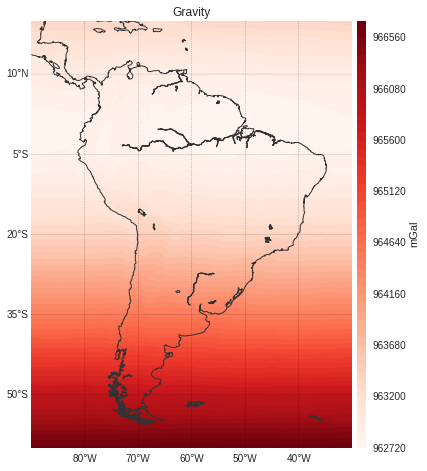

In [13]:
plot_data(lat, lon, grav, shape, 'Reds', ranges=False)
plt.title('Gravity')

## Calculate gravity disturbance

The gravity distance is the raw gravity data minus the effect of the Normal Earth ($\gamma$) calculated at the observation point.

Fatiando a Terra offers the `gamma_closed_form` function that calculates $\gamma$ at any latitude and height using the closed form formula in [Li and Gotze (2001)](http://dx.doi.org/10.1190/1.1487109).

In [14]:
disturbance = grav - normal_gravity.gamma_closed_form(lat, height)

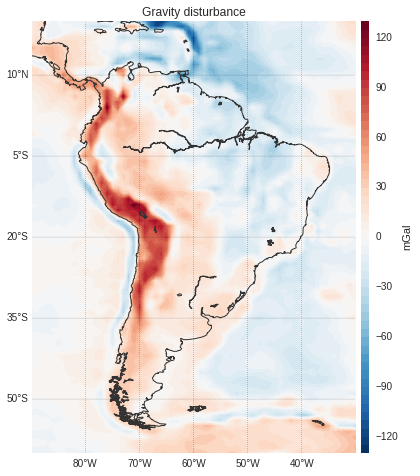

In [15]:
plot_data(lat, lon, disturbance, shape, 'RdBu_r')
plt.title('Gravity disturbance')

## Terrain correction

The next step is to remove the effect of the topography and water layer. Let's load the topography data downloaded from [ICGEM](http://icgem.gfz-potsdam.de/ICGEM/). This data is [ETOPO1](http://ngdc.noaa.gov/mgg/global/global.html) calculated by interpolation on the specified grid points of our data.

In [16]:
topo_data = load_icgem_gdf('../data/topography-sam-s0.1deg.gdf', usecols=[-1])

In [17]:
print(topo_data['metadata'])

generating_institute     gfz-potsdam
     generating_date     2015/08/14
        product_type     topography
                body     earth
           modelname     etopo1_bin_int
          functional     topography_grd (grid)=>bi-linear interpolation
                unit     meter
          refsysname     WGS84
        radiusrefsys     6378137.000 m
          flatrefsys      3.352810664747480E-03   (1/298.25722356300)
       long_lat_unit     degree
      latlimit_north       20.000000000000    
      latlimit_south      -60.000000000000    
      longlimit_west       270.00000000000    
      longlimit_east       330.00000000000    
            gridstep      0.10000000000000    
  latitude_parallels           801
 longitude_parallels           601
number_of_gridpoints        481401
            gapvalue          99999.0000
       weighted_mean     -2.1030878E+03 meter
            maxvalue      6.0260000E+03 meter
            minvalue     -8.3820000E+03 meter
         signal_wrms      

In [18]:
topo, _ = down_sample([topo_data['topography_grd']], topo_data['shape'], every=downsample_every)

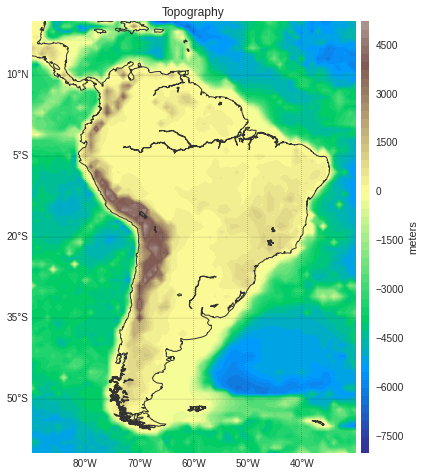

In [19]:
plot_data(lat, lon, topo, shape, cmap='terrain', cblabel='meters')
plt.title('Topography')

We'll make a tesseroid model of the topography so that we can calculate it's gravitational effect in spherical coordinates. The `make_mesh` function of [`moho.py`](moho.py) automates this process for us. Each point in the topography grid is at the center of the top face of a tesseroid.

In [20]:
topo_model = make_mesh(area, shape, topo, reference=0) 

Now we need to set a density value for the topography. We'll use the standard 2670 kg/m³ for the rocks (topography > 0) and -1630 = 1040 - 2670 kg/m³ for water (topography < 0).

In [21]:
topo_density = 2670*np.ones(topo_model.size)
# Density in the oceans is rho_water
topo_density[topo_model.relief < topo_model.reference] = -1630
topo_model.addprop('density', topo_density)

Forward model the effect of the topography in spherical coordinates using tesseroids. Use all available cores for this calculation. It will take a while.

In [22]:
%time topo_effect = tesseroid.gz(lon, lat, height, topo_model, njobs=ncpu)

CPU times: user 20 ms, sys: 40 ms, total: 60 ms
Wall time: 8.45 s


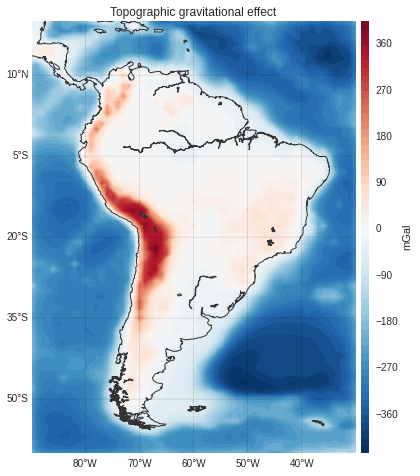

In [23]:
plot_data(lat, lon, topo_effect, shape, cmap='RdBu_r')
plt.title('Topographic gravitational effect')

The Bouguer anomaly will be the disturbance minus the effect of the topography.

In [24]:
bouguer = disturbance - topo_effect

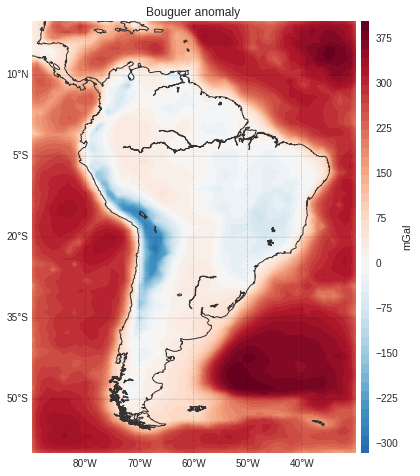

In [25]:
plot_data(lat, lon, bouguer, shape, cmap='RdBu_r')
plt.title('Bouguer anomaly')

## Remove the effect of sediments


We need to remove the gravitational effect of the sedimentary layers from our data to isolate the Moho effect. We'll not consider any other crutal density anomalies because South America is not well represented in the CRUST1.0 model. Instead of assuming a most likely wrong crustal density, we choose to err on the side of simplicity and assume no crustal density anomalies.

Load the CRUST1.0 model for South America.

In [26]:
crust1 = fetch_crust1('../data/crust1.0.tar.gz').cut(area)

Get the three sedimentary layers from the model. We need to transform their density values into density contrasts with respect to the standard crustal density od 2670 kg/m³.

In [30]:
layers = [l.contrast('density', 2670) 
          for l in [crust1.upper_sediments, crust1.middle_sediments, crust1.lower_sediments]]
layer_names = ['Upper sediments', 'Middle Sediments', 'Lower sediments']

Plot the sediment thickness.

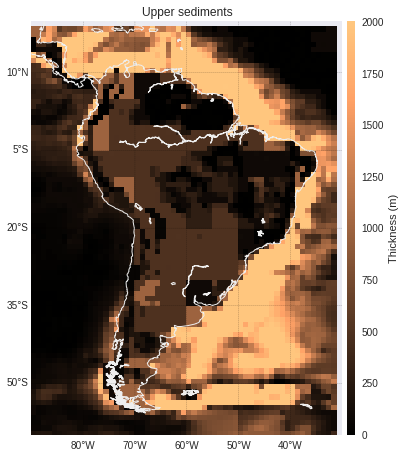

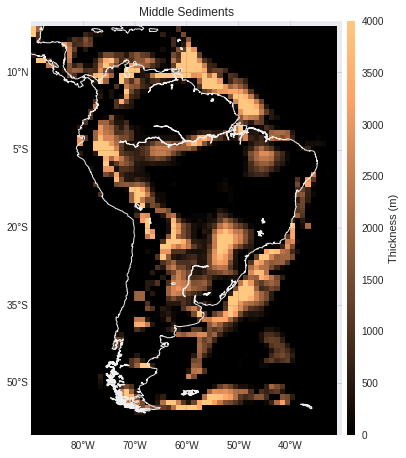

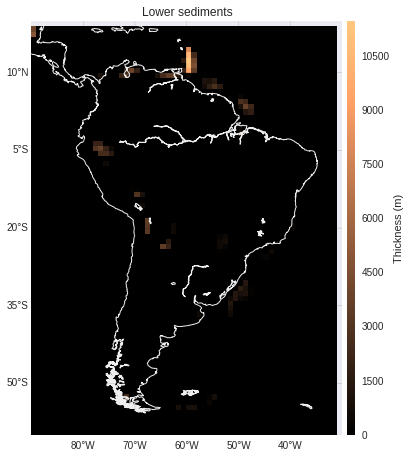

In [36]:
x, y = bm(crust1.lon + 360, crust1.lat) # Transform lat and lon into plot coordinates
for layer_name, layer in zip(layer_names, layers):
    fig = plt.figure(figsize=(7, 6))
    bm.pcolormesh(x, y, layer.thickness, cmap='copper')
    plt.colorbar(pad=0.01, aspect=50).set_label('Thickness (m)')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    bm.drawcoastlines(color="#eeeeee")    
    plt.title(layer_name)
    plt.tight_layout(pad=0)

Calculate the gravitational effect of each layer and the total effect of all layers.

In [39]:
sediment_effects = [tesseroid.gz(lon, lat, height, list(layer.tesseroids), njobs=ncpu) for layer in layers]

In [44]:
total_sediment_effect = np.sum(sediment_effects, axis=0)

Plot them.

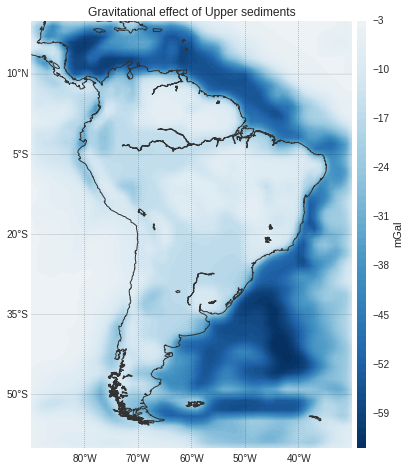

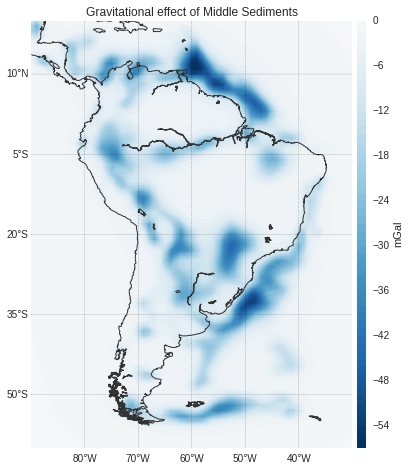

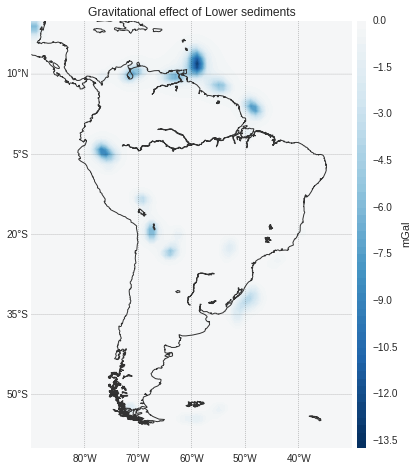

In [41]:
for layer_name, effect in zip(layer_names, sediment_effects):
    plot_data(lat, lon, effect, shape, 'RdBu_r')
    plt.title("Gravitational effect of " + layer_name)

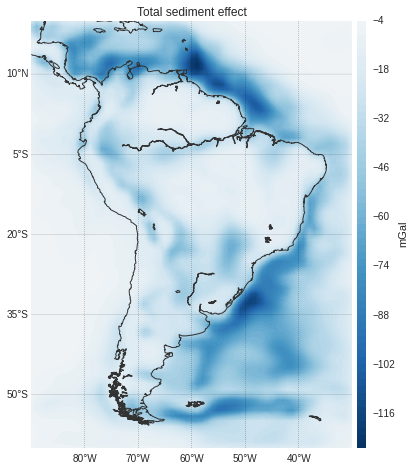

In [47]:
plot_data(lat, lon, total_sediment_effect, shape, cmap='RdBu_r')
plt.title('Total sediment effect')

Calculate the sediment-free Bouguer anomaly.

In [48]:
sedfree_bouguer = bouguer - total_sediment_effect

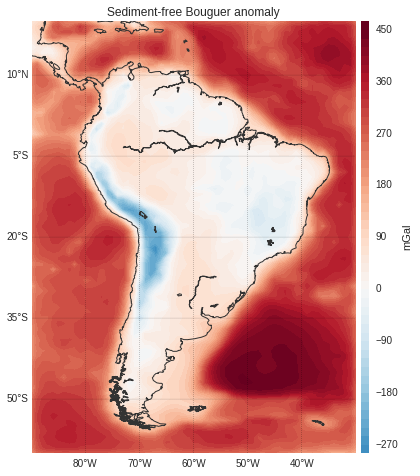

In [49]:
plot_data(lat, lon, sedfree_bouguer, shape, cmap='RdBu_r')
plt.title('Sediment-free Bouguer anomaly')

## Save the data

In [52]:
header = """# shape:
# {nlat} {nlon}
# lat  lon  height  topo  gravity  disturbance  topo_effect  bouguer  sediment_effect  moho_anomaly
""".format(nlat=shape[0], nlon=shape[1])
with open('../data/processed-goco5s-data-sam-h50km.txt', 'w') as f:
    f.write(header)
    np.savetxt(f, np.c_[lat, lon, height, topo, grav, disturbance, topo_effect, bouguer, 
                        total_sediment_effect, sedfree_bouguer])

[]()